In [140]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import datetime, timedelta
import pulp as pl
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 10.0

import yaml
import importlib

# Skip components installation
import os
import sys
sys.path.insert(0, os.path.abspath('.'))

#### Variables and constraints

In [158]:
import components
importlib.reload(components)
from components import *

In [159]:
H = Model(config_file='general_config_file.yaml', elements_list='elements_list.yaml')
H.initialize_hubs()
H.build_environment_level_variables_and_constraints(log=False)
H.connect_environments()
H.add_hubs_equations_to_model()
H.solve()

c:\user\SG10290\Documents\Simu\components.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.y_vars.insert(loc=0,
c:\user\SG10290\Documents\Simu\components.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.y_vars.insert(loc=0,
c:\user\SG10290\Documents\Simu\components.py:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

hub_electricity_house and hub_electricity_car connected
hub_heat_house and hub_heat_car connected
hub_electricity_trailer and hub_electricity_car connected
hub_electricity_trailer and hub_electricity_house connected
Problem solved with status: Optimal


100%|██████████| 168/168 [00:00<00:00, 5740.75it/s]


In [160]:
H.hubs

,distance,electricity,heat,oil
car,<components.Hub object at 0x000001E40D36F100>,<components.Hub object at 0x000001E4149BCF50>,<components.Hub object at 0x000001E4111957B0>,<components.Hub object at 0x000001E4149BC910>
house,NaN,<components.Hub object at 0x000001E410832E40>,<components.Hub object at 0x000001E414AAFCE0>,NaN
trailer,NaN,<components.Hub object at 0x000001E40FD37D10>,NaN,NaN


In [161]:
H.objective_value

np.float64(13.428192078382002)

#### Plot

In [39]:
def get_label(string):
    words = string.split('_')
    translation = ''
    for word in words:
        # translation += dictionnary[word] + ' '
        translation += word + ' '
    return translation[:-1]

def capitalise(string):
    return string[0].upper() + string[1:]

# Build a proper timeline
def get_timeline():
    start = datetime(2025, 7, 14, 0)
    end = datetime(2025, 7, 20, 23)

    timeline = []
    d = start
    while d <= end:
        timeline.append(d)
        d += timedelta(hours=1)
    
    return timeline


def duplicate(dispatch):
    for column in dispatch.columns:
        # Duplicate and reverse every energy flow between hubs
        if 'hub' in column:
            words = column.split('_')
            words_reordered = [words[i] for i in [0, 4, 2, 3, 1, 5]]
            new_column = '_'.join(words_reordered)
            dispatch.insert(loc=1, column=new_column, value=-dispatch[column])
    return dispatch

colors = ['#BFA85B',
 '#6C3E80',
 '#219EBC',
 '#484C7E',
 '#C7754C',
 '#EC674E',
 '#82A9A1',
 '#B41F58',
 '#4A62AB',
 '#ef476f',
 '#012640',
 '#FFBC42',
 '#0496FF',
 '#D81159',
 '#8F2D56',
 '#006BA6',
 '#FFFFFF',
]

In [134]:
def plot_vars_car_connected_version(dispatch, data, top_var, variables, ax, title, price=False):
    # variables = list(set(dispatch.columns) & set(variables))
    variables = [var for var in variables if var in dispatch.columns]

    # Get max and sum values
    max_value = dispatch[variables].max().max()
    positive_total = dispatch[variables].clip(lower=0).sum().sum()
    negative_total = dispatch[variables].clip(upper=0).sum().sum()
    
    # Indicate when car is connected 
    ax.fill_between(x=dispatch['time'], y1=data['house_car_connection']*max_value, step="mid", alpha=0.2, color='#219EBC', hatch='/', edgecolor='w', label='Time slots when car is at home')
    # ax.step(x=dispatch['time'], y=data['Car_connected']*max_value, where='mid', alpha=0.2, color=colors['BEV'])
    
    # Plot the aggregated variable as a bold line
    if type(top_var)==str:
        ax.step(x=dispatch['time'], y=dispatch[top_var], label=capitalise(get_label(top_var)), lw=2., where='mid', zorder=2)
    

    # ax.bar(x=dispatch['time'].values[0], height=data['Car_connected'].values[0]*max_value, alpha=0.2, color=colors['BEV'], width=dispatch['time'].values[1]- dispatch['time'].values[0], hatch='/', edgecolor='w', label='Time slots when BEV is at home')
    # for t in range(1, len(dispatch)):
    #     ax.bar(x=dispatch['time'].values[t], height=data['Car_connected'].values[t]*max_value, alpha=0.2, color=colors['BEV'], width=dispatch['time'].values[1]- dispatch['time'].values[0], hatch='/', edgecolor='w')

    # Stack plot of the components variables
    positive_stack = np.zeros(len(dispatch))
    negative_stack = np.zeros(len(dispatch))

    zorders = [len(variables)-i+3 for i in range(len(variables))]
    for i, var in enumerate(variables):
        positive_values = dispatch[var].clip(lower=0)
        negative_values = dispatch[var].clip(upper=0)
        if top_var=='PV' or top_var=='conso':
            rate = dispatch[var].sum()/total_top_var
            label = capitalise(get_label(var)) + ' (' + str(round(rate*100)) + '%)'
        else:
            try:
                positive_rate = positive_values.sum()/positive_total
            except ZeroDivisionError:
                positive_rate = 0.
            try:
                negative_rate = negative_values.sum()/negative_total
            except ZeroDivisionError:
                negative_rate = 0.
            label = capitalise(get_label(var)) + ' (' + str(round(positive_rate*100)) + '%$\\uparrow$ ' + str(round(negative_rate*100)) + '%$\\downarrow$)'

        # Positive values
        ax.bar(x=data['time'], height=positive_values,
            color=colors[i], label=label,
            width=data['time'].values[1]- data['time'].values[0], zorder=zorders[i], bottom=positive_stack)
        # Negative values
        ax.bar(x=data['time'], height=negative_values,
            color=colors[i], # label=get_label(var) + ' (' + str(round(rate*100)) + '%)',
            width=data['time'].values[1]- data['time'].values[0], zorder=zorders[i], bottom=negative_stack)
        
        positive_stack = positive_stack + positive_values
        negative_stack = negative_stack + negative_values

    # Plot electricity prices with its own axis
    if price:
        ax2 = ax.twinx()
        ax2.step(x=data['time'], y=data['Electricity_price (euros/MWh)'], color='#333333', alpha=0.7, where='mid', label='Electricity price')
        ax2.set_ylabel('Electricity price (€/MWh)')
        ax2.spines[['left', 'top']].set_visible(False)
        ymin, ymax = ax.get_ylim()
        ymin2, ymax2 = data['Electricity_price (euros/MWh)'].min(), data['Electricity_price (euros/MWh)'].max()
        YMIN = ymin*(ymax2-ymin2)/(ymax-ymin)*3
        YMAX = ymax*(ymax2-ymin2)/(ymax-ymin)*3
        ax2.set_ylim(YMIN, YMAX)

    ax.set_xlim(data['time'].values[0], data['time'].values[-1])
    ax.set_ylabel('Energy (Wh)')
    ax.set_title(title)
    ax.spines[['right', 'top']].set_visible(False)

    return ax

def combination_plot(dispatch, data, top_var, variables, title, price=False):
    fig = plt.figure(figsize=(21, 6), layout='constrained')
    ax = fig.add_subplot(111)
    ax = plot_vars_car_connected_version(dispatch, data, top_var, variables, ax, title=title, price=price)
    # Place a legend under the subplot
    fig.legend(loc='outside lower center', ncols=4, frameon=False)
    fig.savefig(str(H.run_num) + '_' + H.run_name + ' ' + title + '.png')


#### Display

In [162]:
dispatch = H.dispatch
dispatch.time = get_timeline()
dispatch = dispatch.astype({'time': 'datetime64[ns]'})
dispatch = duplicate(dispatch)

data = H.data
data.time = get_timeline()
data = data.astype({'time': 'datetime64[ns]'})

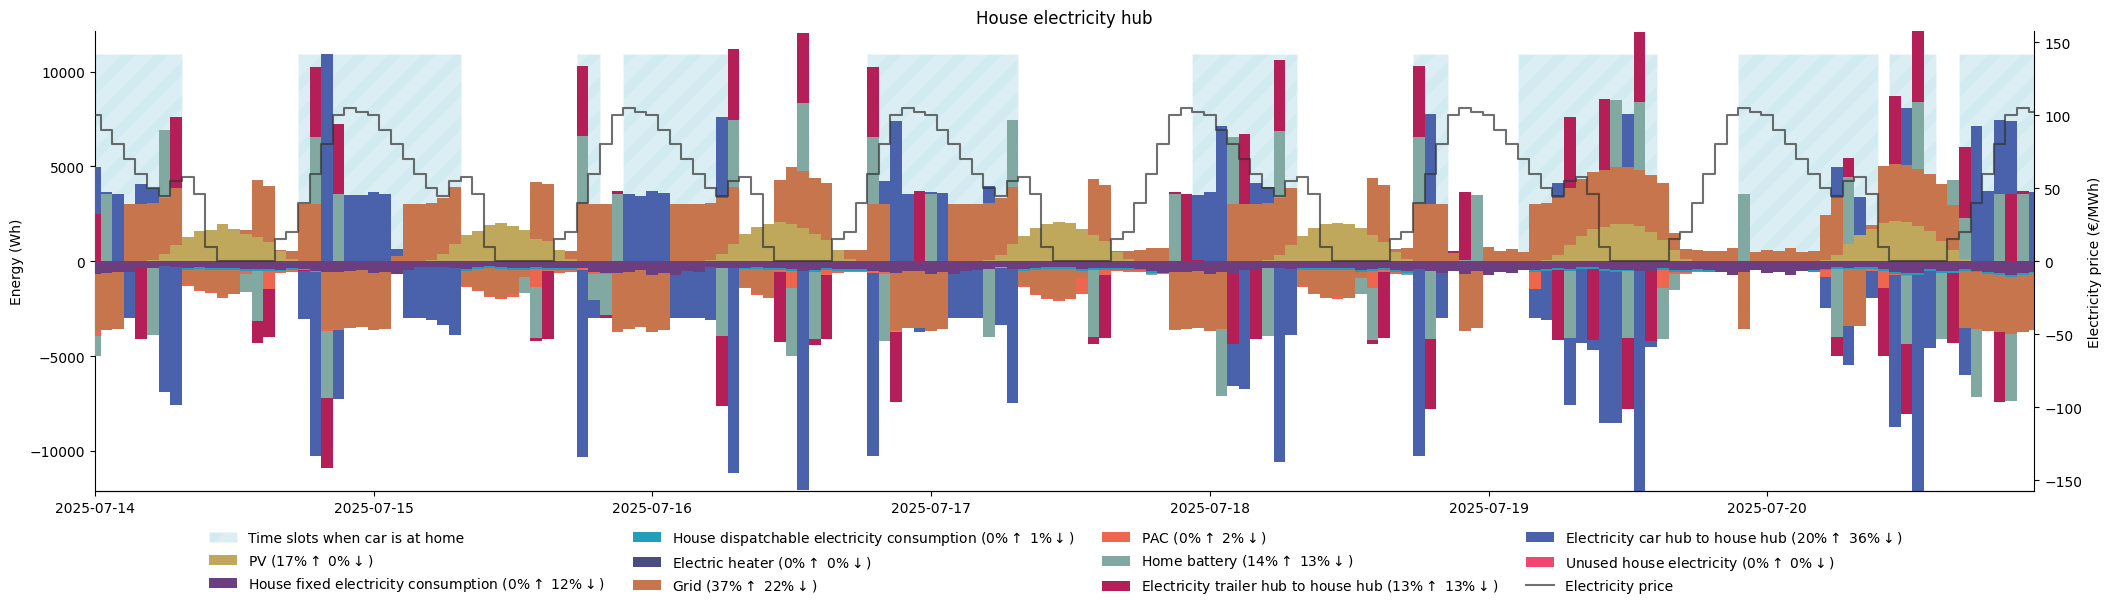

In [163]:
combination_plot(dispatch, data, None, [
                        'PV',
                        'house_fixed_electricity_consumption', 
                        'house_dispatchable_electricity_consumption',
                        'electric_heater',
                        'grid',
                        'PAC',
                        'home_battery',
                        'electricity_trailer_hub_to_house_hub',
                        'electricity_car_hub_to_house_hub',
                        'unused_house_electricity',
                        ], title='House electricity hub', price=True)

In [122]:
H.components['Production']['PV'].factor.value()

2.8864727

In [123]:
H.components['Storage']['home_battery'].factor.value()

0.71075172

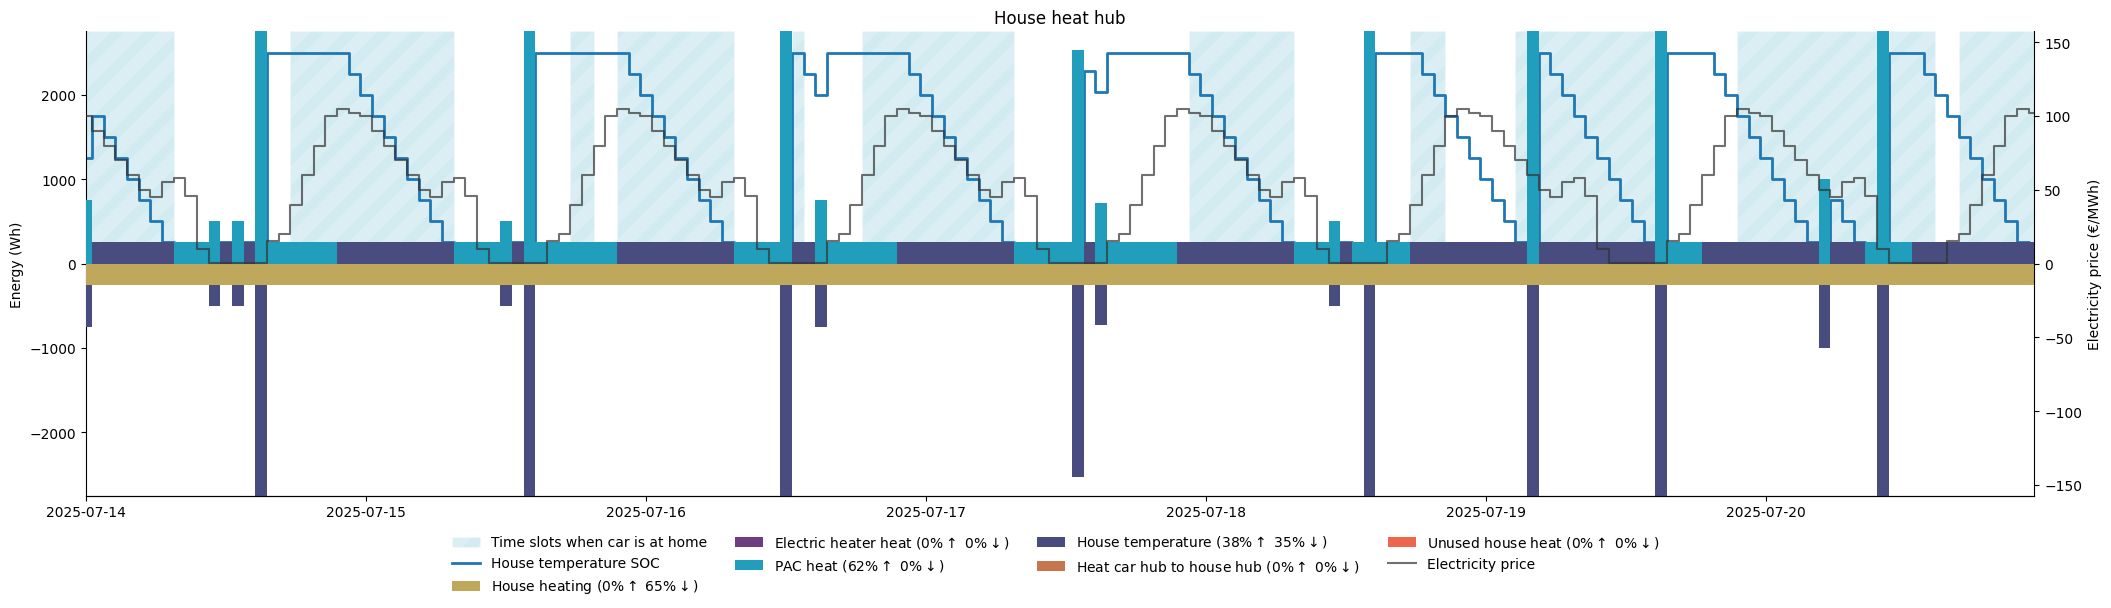

In [135]:
combination_plot(dispatch, data, 'house_temperature_SOC', ['house_heating',
                        'electric_heater_heat',
                        'PAC_heat',
                        'house_temperature',
                        'heat_car_hub_to_house_hub',
                        'unused_house_heat',
                        ], title='House heat hub', price=True)

In [ ]:
combination_plot(dispatch, data, None, ['heat_house_hub_to_car_hub',
                        'combustion_engine_heat',
                        'electric_engine_heat',
                        'unused_car_heat',
                        ], title='Car heat hub', price=True)

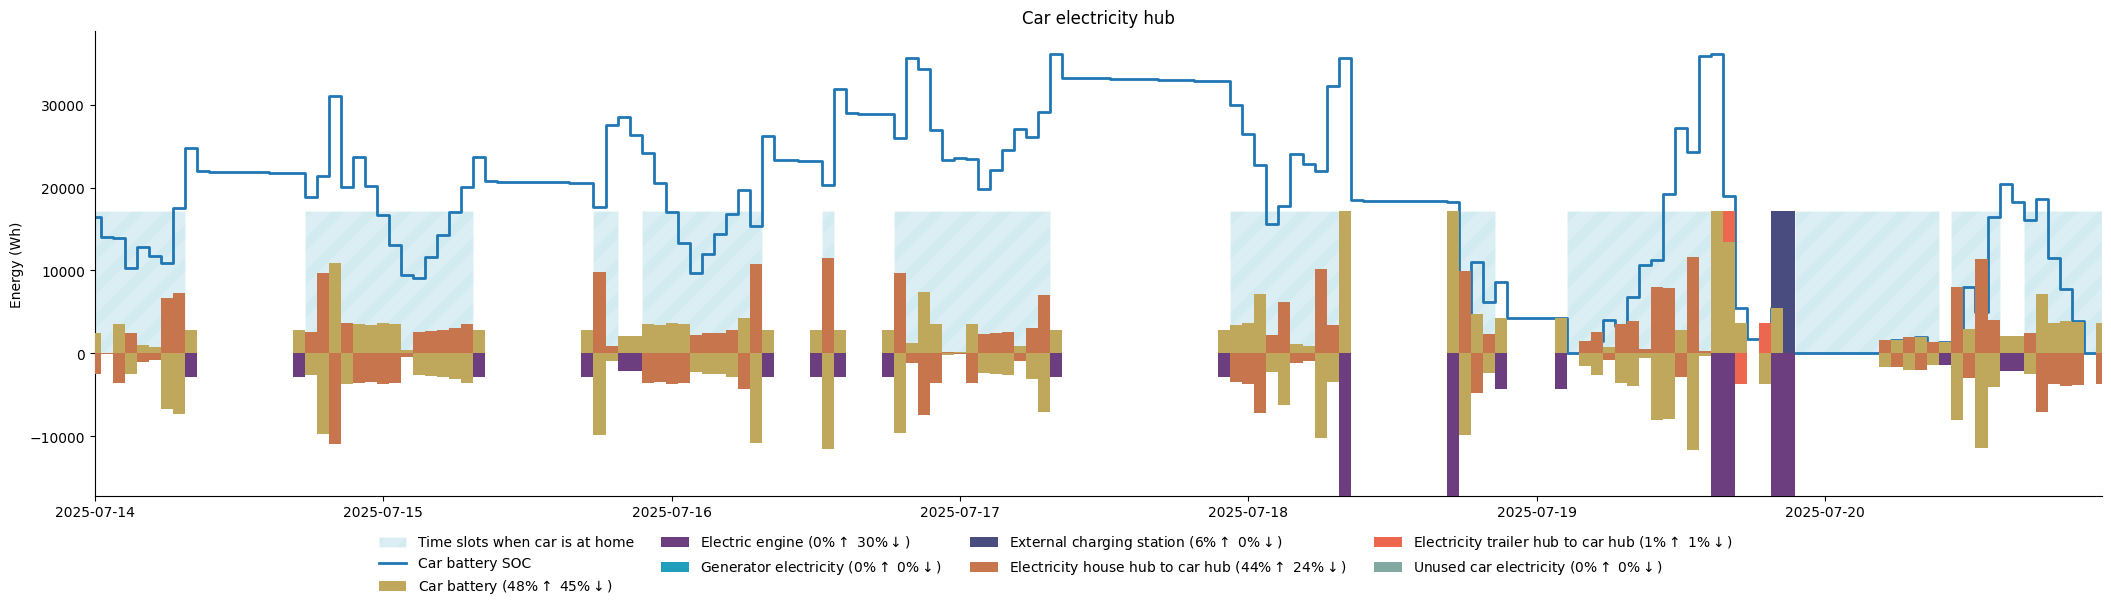

In [138]:
combination_plot(dispatch, data, 'car_battery_SOC', [
                        'car_battery',
                        'electric_engine',
                        'generator_electricity',
                        'external_charging_station',
                        'electricity_house_hub_to_car_hub',
                        'electricity_trailer_hub_to_car_hub',
                        'unused_car_electricity',
                        ], title='Car electricity hub',
                        price=False)

In [ ]:
combination_plot(dispatch, data, None, ['gas_station',
                        'combustion_engine',
                        'generator',
                        ], title='Car oil hub')

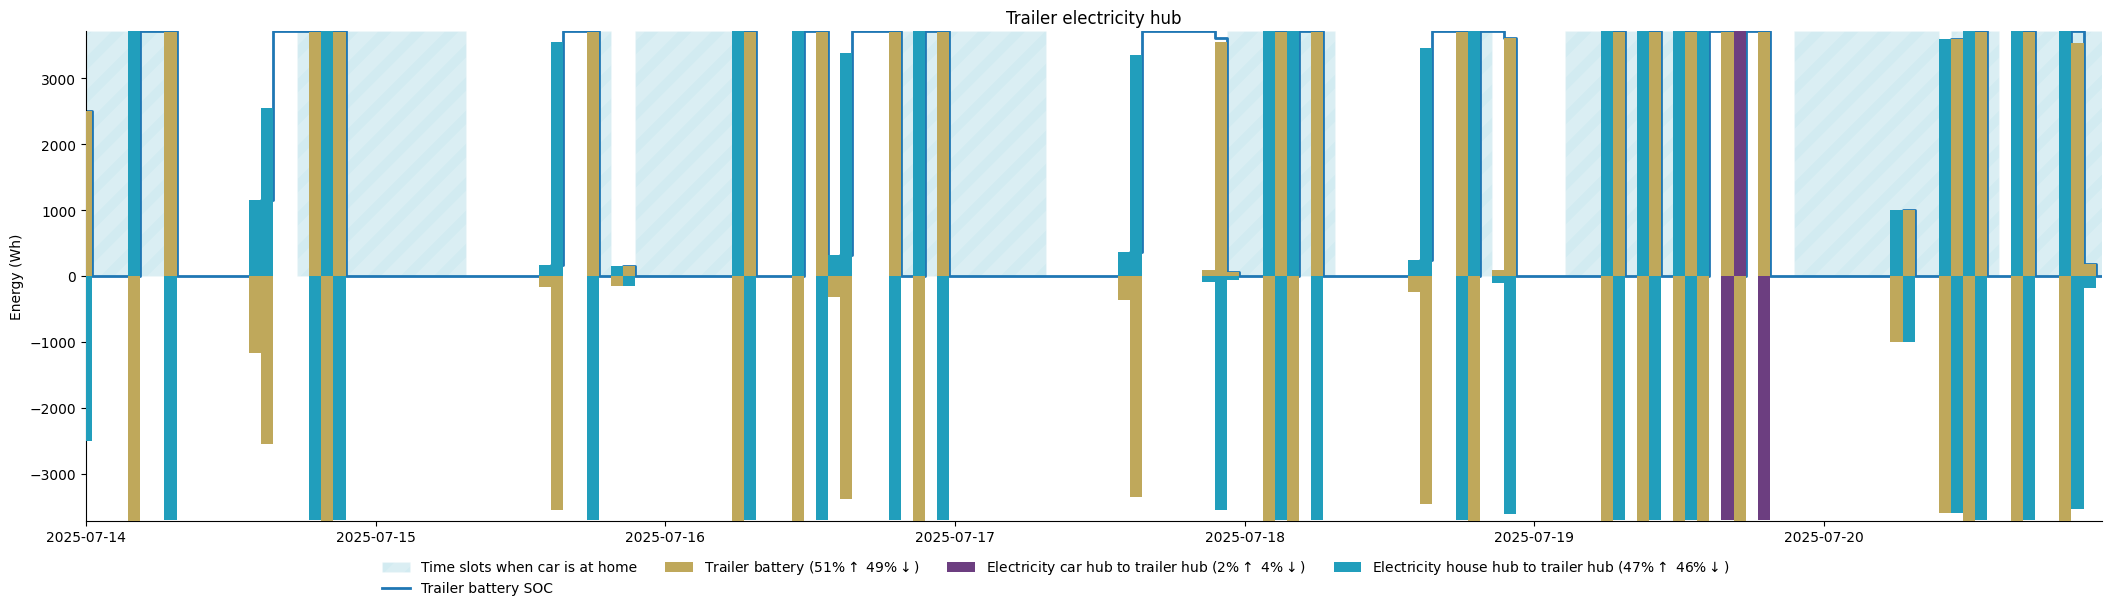

In [139]:
combination_plot(dispatch, data, 'trailer_battery_SOC', ['trailer_battery',
                        'electricity_car_hub_to_trailer_hub',
                        'electricity_house_hub_to_trailer_hub',
                        ], title='Trailer electricity hub')

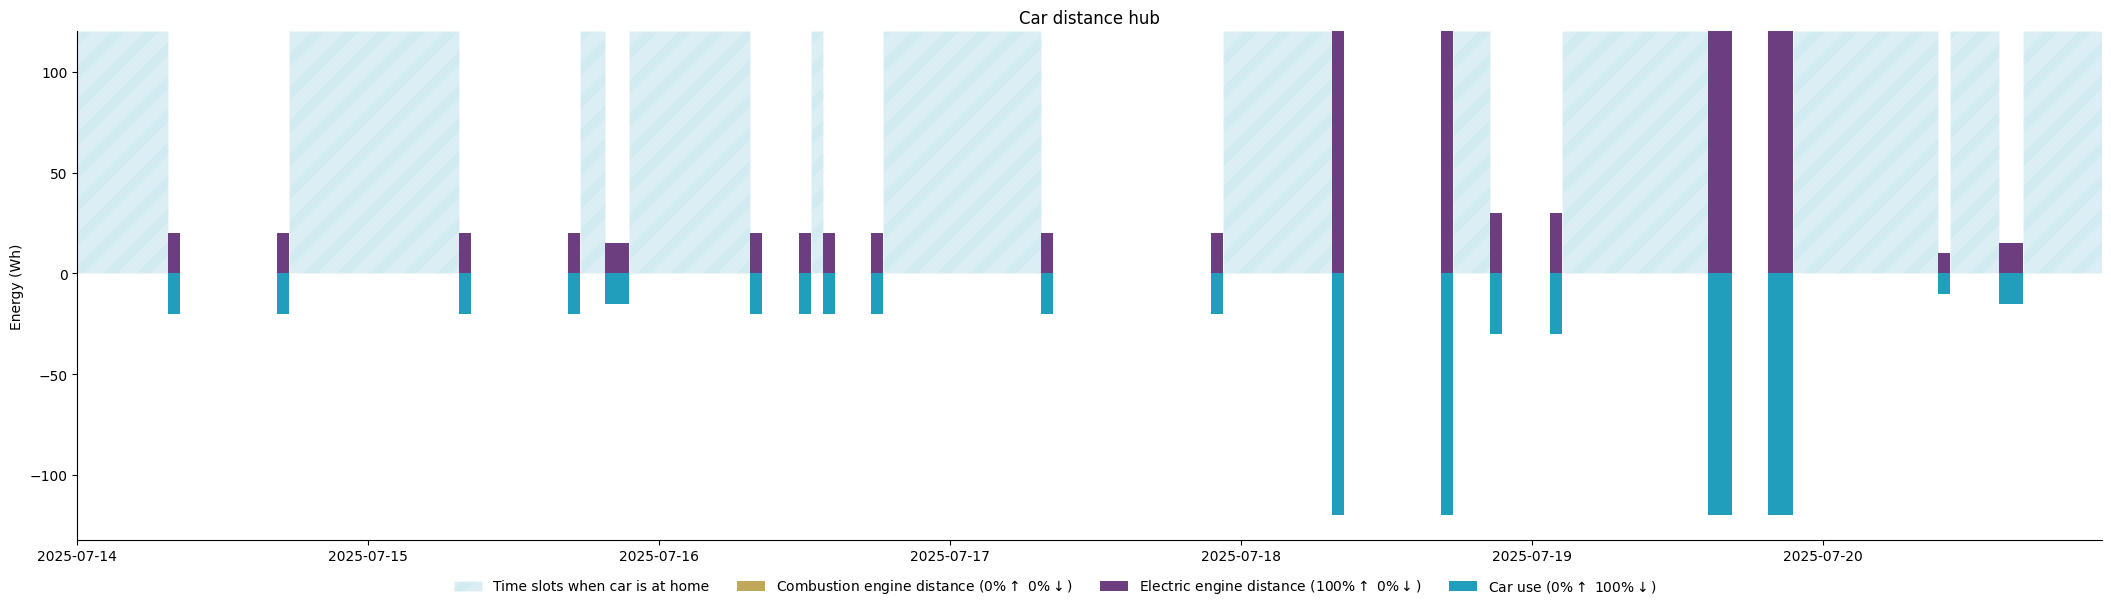

In [127]:
combination_plot(dispatch, data, None, ['combustion_engine_distance',
                        'electric_engine_distance',
                        'car_use'],
                        title='Car distance hub')

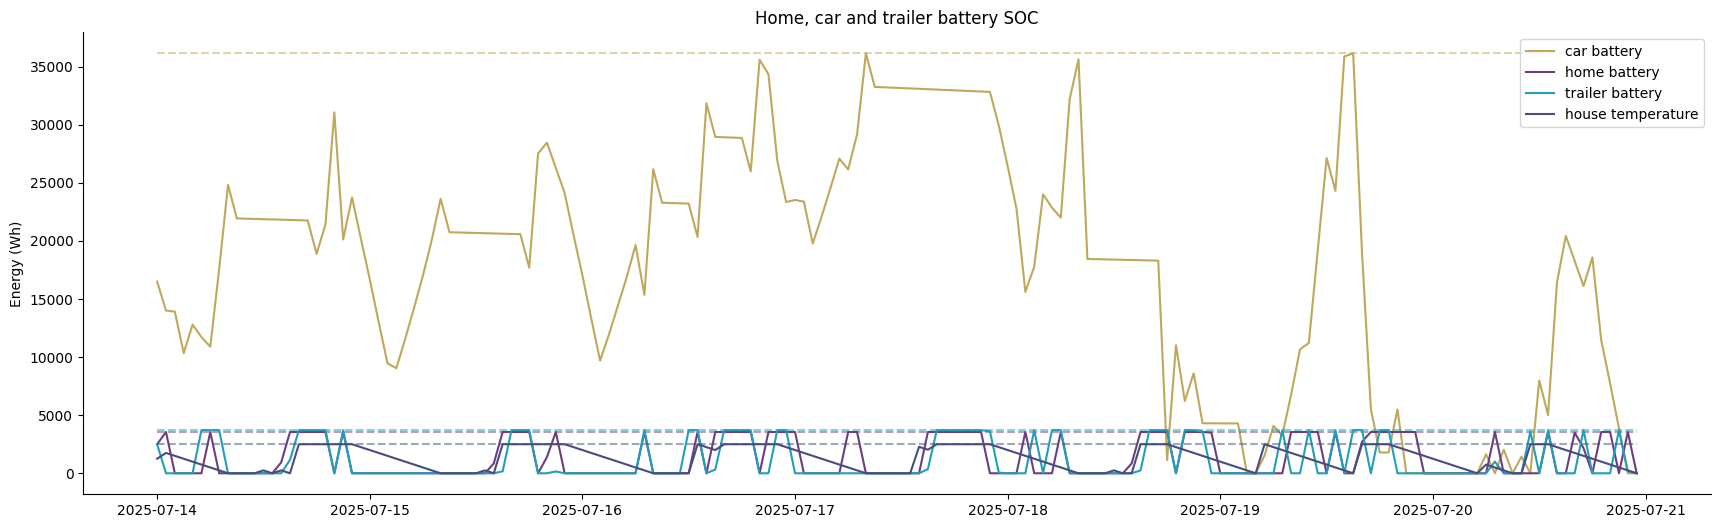

In [129]:
dispatch.index = dispatch['time']

fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
variables = ['car_battery', 'home_battery', 'trailer_battery', 'house_temperature']
for i, var in enumerate(variables):
    try:
        total_capa = H.components['Storage'][var].capacity * value(H.components['Storage'][var].factor)
        ax.hlines(total_capa, xmin=dispatch['time'].values[0], xmax=dispatch['time'].values[-1], color=colors[i], ls='--', alpha=0.5)
        ax.plot(dispatch[var + '_SOC'], color=colors[i], label=get_label(var))
    except KeyError:
        pass
    ax.legend()
    ax.set_ylabel('Energy (Wh)')
    ax.set_title('Home, car and trailer battery SOC')
ax.spines[['right', 'top']].set_visible(False)